# Clasificación de vocales

## Creación DB

## Importar librerias


* os:
* pathlib:
* matplotlib:
* seaborn:
* pandas:
* numpy:
* tensorflow:
* sklearn:
* pickle:
* datetime:
* Ipython:
* pydub:
* scipy:
* noisereduce:
* sounddevice:

In [1]:
# Tratamiento de archivos
import os
from os import listdir
from os.path import isfile, join
import pathlib

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

#Manejo de matrices y Df
import pandas as pd
import numpy as np

#Librerias redes neuronales
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split

#Guardar modelos
import pickle
from datetime import datetime

from IPython import display

# Segmemntar audio
from pydub import AudioSegment
from scipy.io import wavfile
from scipy.io.wavfile import write,read
import noisereduce as nr
import sounddevice as sd
import soundfile

from utils.model_utils import decode_audio,get_label,get_spectrogram,get_waveform_and_label
from utils.model_utils import recortar_audio,play_audio,predict_vocal,plot_spectrogram

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Construcción DB

Listado de todos los archivos .wav ubicados dentro de la carpeta “audios” en el directorio donde se encuentra el notebook.

In [10]:
mypath='audios/'
onlyfiles = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f)) if f.endswith('.wav')]

Preprocesamiento de audios, se realiza una reducción de canales de audio para convertirlos de estéreo a mono.

In [11]:
for file in onlyfiles:
    sound = AudioSegment.from_wav(file)
    sound = sound.set_channels(1)
    sound.export(file, format="wav")

Reducción de ruido

In [12]:
rate_list=16000
for file in onlyfiles:
    rate, data = wavfile.read(file)
    reduced_noise = nr.reduce_noise(y=data, sr=rate)
    soundfile.write(file, reduced_noise, rate_list, subtype='PCM_16')

Creación del data frame “df_audios” donde se almacena toda la información

In [13]:
df_audios=pd.DataFrame([get_waveform_and_label(file) for file in onlyfiles],columns=['file','audio','label'])
df_audios['rate']=rate_list
df_audios

,file,audio,label,rate
0,audios/A_001_mujer_paula.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",A,16000
1,audios/A_002_mujer_paula.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",A,16000
2,audios/A_003_mujer_paula.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",A,16000
3,audios/A_004_hombre_paula.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",A,16000
4,audios/A_005_mujer_paula.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",A,16000
...,...,...,...,...
620,audios/U_121_mujer_gabriel.wav,"[-9.1552734e-05, -3.0517578e-05, -6.1035156e-0...",U,16000
621,audios/U_122_mujer_gabriel.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",U,16000
622,audios/U_123_mujer_gabriel.wav,"[3.0517578e-05, 3.0517578e-05, 3.0517578e-05, ...",U,16000
623,audios/U_124_mujer_gabriel.wav,"[-6.1035156e-05, -3.0517578e-05, -3.0517578e-0...",U,16000


Recortamos los audios dentro del dataframe

In [14]:
amp_recortar=0.03
df_audios.audio=df_audios.audio.apply( lambda x: recortar_audio(x,amp_recortar))
df_audios['largo_audio']=df_audios.audio.apply( lambda x: len(x))

Creación de la columna “spectograma” en el data frame, que contiene el espectrograma correspondiente para cada uno de los audios.

In [16]:
spec_recortar=int(df_audios.largo_audio.quantile(.7))
df_audios['spectograma']=df_audios.audio.apply(lambda x:get_spectrogram(x,spec_recortar))

Creación de la columna “label_modelo” en el data frame, que contiene las etiquetas numerícas de cada uno de los audios.

In [17]:
etiquetas=df_audios.label.unique()
df_audios['label_modelo']=df_audios.label.apply(lambda x: tf.argmax(x == etiquetas).numpy())

In [18]:
df_audios.head()

,file,audio,label,rate,largo_audio,spectograma,label_modelo
0,audios/A_001_mujer_paula.wav,"[0.03479004, 0.044311523, 0.05343628, 0.061676...",A,16000,15530,"[[[0.4913473], [0.64532095], [0.5307749], [0.5...",0
1,audios/A_002_mujer_paula.wav,"[0.030578613, 0.03164673, 0.032348633, 0.03240...",A,16000,14348,"[[[0.04238976], [0.2416146], [0.43635228], [0....",0
2,audios/A_003_mujer_paula.wav,"[0.03274536, 0.035949707, 0.038726807, 0.04101...",A,16000,11180,"[[[0.21957806], [1.4327693], [2.1369364], [1.9...",0
3,audios/A_004_hombre_paula.wav,"[0.036132812, 0.04888916, 0.06072998, 0.070709...",A,16000,12617,"[[[0.031638123], [0.0038370125], [0.41430196],...",0
4,audios/A_005_mujer_paula.wav,"[0.03643799, 0.04510498, 0.0501709, 0.05093383...",A,16000,11107,"[[[0.012957494], [0.025367731], [0.039118778],...",0


## Visualización

In [19]:
df_audios[df_audios.file=='audios/A_081_mujer_Tomas.wav'].squeeze()

file                                 audios/A_081_mujer_Tomas.wav
audio           [0.032928467, 0.0440979, 0.053253174, 0.060028...
label                                                           A
rate                                                        16000
largo_audio                                                 12414
spectograma     [[[0.005121153], [0.047875322], [0.05899068], ...
label_modelo                                                    0
Name: 80, dtype: object

In [20]:
play_audio(df_audios.iloc[80,:])

Label: A
Waveform shape: (12414,)
Audio playback


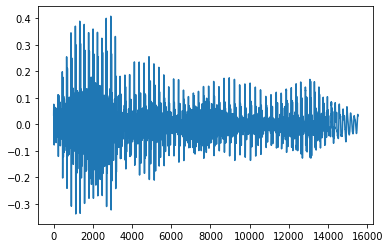

In [21]:
inicio=np.where(df_audios.audio[0]>0.02)[0][0]
final=np.where(df_audios.audio[0]>0.02)[0][-1]
plt.plot(df_audios.audio[0][inicio:final])

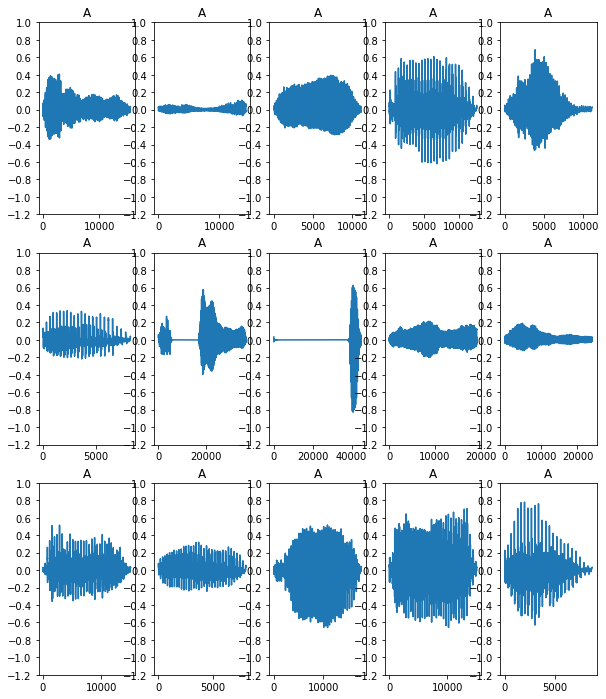

In [22]:
## Si queremos vizualizar la informacion de los audios

rows = 3
cols = len(df_audios.label.unique())
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i,row in df_audios.iloc[:n,:].iterrows():
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(row['audio'])
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = row.label
    ax.set_title(label)

plt.show()

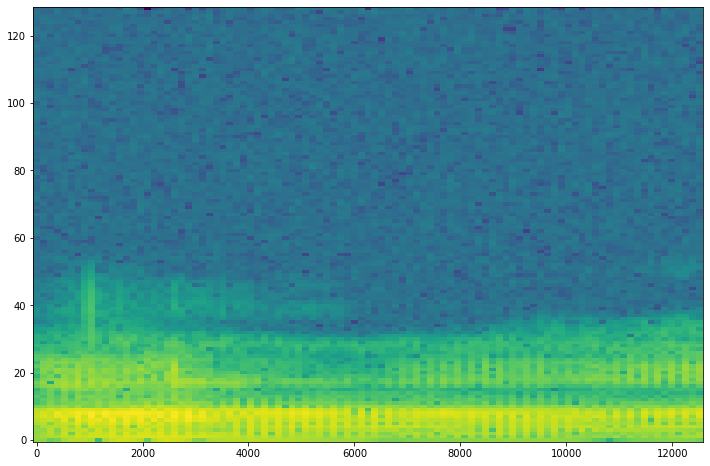

In [23]:
fig, axes =plt.subplots(1, figsize=(12, 8))    
plot_spectrogram(df_audios.spectograma[0],axes)

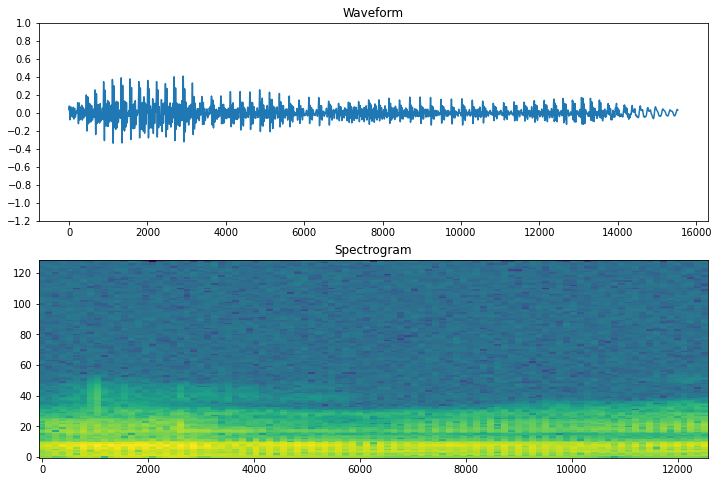

In [24]:
fig, axes = plt.subplots(2, figsize=(12, 8))

axes[0].plot( df_audios.audio[0])
axes[0].set_yticks(np.arange(-1.2, 1.2, 0.2))
axes[0].set_title('Waveform')



plot_spectrogram(df_audios.spectograma[0], axes[1])
axes[1].set_title('Spectrogram')
plt.show()

## Creación del modelo

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_audios.spectograma, df_audios.label_modelo, test_size=0.3, random_state=42,stratify=df_audios.label_modelo)

In [26]:
X_train[0].shape

(97, 129, 1)

Tipos de capas:
* layers.Input:
* layers.Dense: La capa densa es  utilizada para crear una capa profundamente conectada en la red neuronal donde cada una de las neuronas de las capas densas recibe información de todas las neuronas de la capa anterior. Básicamente, realiza el producto escalar de todos los valores de entrada junto con los pesos para obtener la salida.
* layers.Flatten: Reforma el tensor para que tenga una forma que sea igual al número de elementos contenidos en el tensor, esto es lo mismo que hacer una matriz 1d de elementos.
* layers.Dropout: Establece aleatoriamente las unidades de entrada en 0 con una frecuencia definida en cada paso durante el tiempo de entrenamiento, lo que ayuda a evitar el sobreajuste.
* layers.Normalization: Esta capa le ayuda a transferir la entrada a un forma estandarizada. Esta capa tendrá una media de cero y una desviación estándar de uno.
* layers.Resizing: Esta capa cambia el tamaño de una entrada de imagen a una altura y ancho de destino.
* layers.Conv2D: Esta capa crea un núcleo de convolución que se convoluciona con la entrada de la capa para producir un tensor de salidas.
* layers.MaxPooling2D:

Funciones de activacion:
* Escalonada:
* Lineal: 
* Sigmoidal:
* Softmax:
* Tanh:
* ReLU:
* Leaky ReLU:

In [27]:
#Dimension de datos de entrada 

input_shape = X_train[0].shape
print('Input shape:', input_shape)
num_labels = len(etiquetas)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
norm_layer.adapt(data=np.asarray(X_train.to_list()).astype('float32'))
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.


model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (97, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 128)      0         
 )                            

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Entrenamiento

In [29]:
EPOCHS = 100
history = model.fit(
    x=np.asarray(X_train.to_list()).astype('float32'),
    y=np.asarray(y_train.to_list()).astype('float32'),
    validation_split=0.3,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=30),
    verbose=0
)

Epoch 55: early stopping


A continuacion evaluamos los resultados con el conjunto de test

In [30]:
y_pred = np.argmax(model.predict(np.asarray(X_test.to_list()).astype('float32')), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 84%


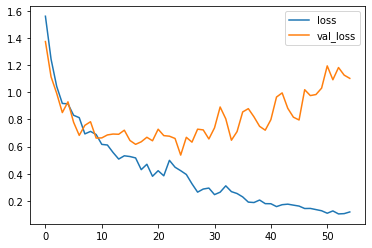

In [31]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

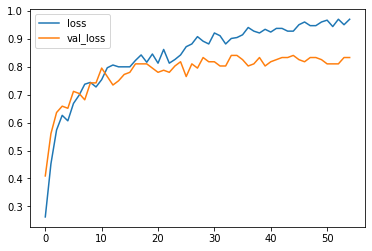

In [32]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['loss', 'val_loss'])
plt.show()

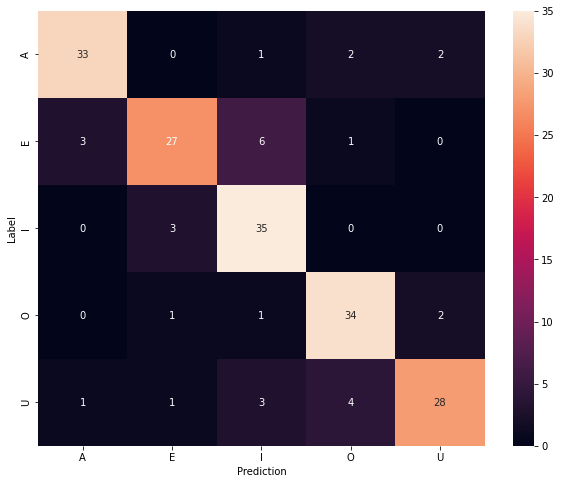

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=etiquetas,
            yticklabels=etiquetas,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Predicción

Utilizamos la funcion que definimos antes la cual hace el preprocesamiento al audio de entrada y emplea el modelo entrenado para hacer la prediccion de la vocal

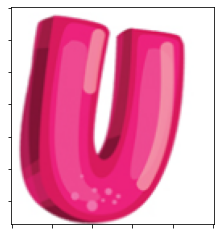

In [46]:
file_name="test"

vars=[amp_recortar,spec_recortar]

predict_vocal(model,vars,"test_audio",record=True)


## Exportar modelo

In [143]:
#Guardamos las variables que requiere la funcion de prediccion
dt_string = "model_name_vars"
output = 'modelos/'
amp_recortar=0.03
spec_recortar=int(df_audios.largo_audio.quantile(.7))
pickle.dump( [amp_recortar,spec_recortar], open( output + dt_string +".pkl", "wb" ) )


INFO:tensorflow:Assets written to: ram://c5e84944-518b-4218-b35d-4f3276d1912a/assets


Guardar el modelo

In [43]:
tf.keras.models.save_model(model, "model_name")

INFO:tensorflow:Assets written to: model\assets


Cargar el modelo

In [ ]:
modelo_load=tf.keras.models.load_model("model_name")

In [ ]:
vars=pickle.load(open("model_name_vars.pkl", 'rb'))
#tf.saved_model.save(model2, "model")
modelo_load=tf.keras.models.load_model("model_name")